In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
def BGRtoYUV(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

In [3]:
orientations = 8
pixels_per_cell = 8
cells_per_block = 2

def hog_features(channel, visualise=False):
    if visualise == True:
        features, hog_image = hog(channel, orientations=orientations,
                                  pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                                  cells_per_block=(cells_per_block, cells_per_block),
                                  transform_sqrt=False, visualise=True, feature_vector=False)
        return hog_image
    else:      
        features = hog(channel, orientations=orientations,
                       pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                       cells_per_block=(cells_per_block, cells_per_block),
                       transform_sqrt=False, visualise=False, feature_vector=True)
        return features

In [4]:
def derive_features(img):
    img = BGRtoYUV(img)
    features_y = hog_features(img[:,:,0])
    features_u = hog_features(img[:,:,1])
    features_v = hog_features(img[:,:,2])
    return np.concatenate((features_y, features_u, features_v))

In [5]:
ex_vehicle = cv2.imread('vehicles/GTI_Right/image0121.png')
ex_non_vehicle = cv2.imread('non-vehicles/GTI/image49.png')

yuv_vehicle = BGRtoYUV(ex_vehicle)
yuv_non_vehicle = BGRtoYUV(ex_non_vehicle)

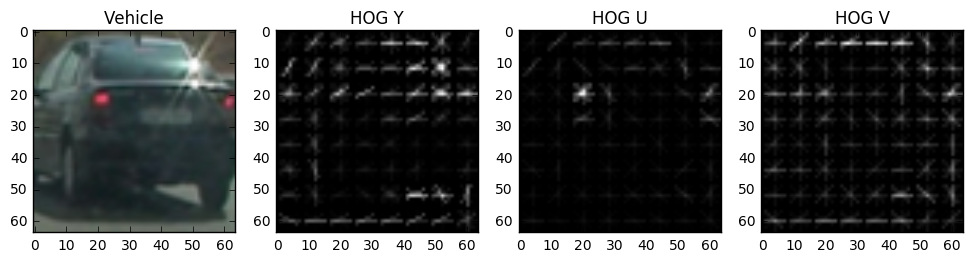

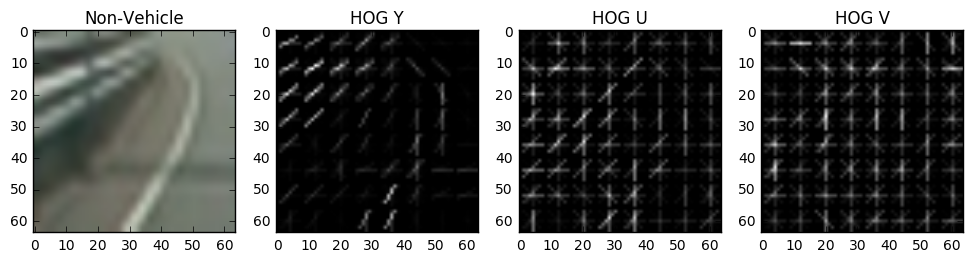

In [6]:
hog_vehicle=[]
hog_non_vehicle=[]

for i in range(0,3):
    hog_vehicle.append(hog_features(yuv_vehicle[:,:,i], visualise=True))
    hog_non_vehicle.append(hog_features(yuv_non_vehicle[:,:,i], visualise=True))

fig = plt.figure(1, figsize=(12, 9))
plt.subplot(141)
plt.imshow(cv2.cvtColor(ex_vehicle, cv2.COLOR_BGR2RGB))
plt.title('Vehicle')
plt.subplot(142)
plt.imshow(hog_vehicle[0], cmap='gray')
plt.title('HOG Y')
plt.subplot(143)
plt.imshow(hog_vehicle[1], cmap='gray')
plt.title('HOG U')
plt.subplot(144)
plt.imshow(hog_vehicle[2], cmap='gray')
plt.title('HOG V')
fig = plt.figure(2, figsize=(12,9))
plt.subplot(141)
plt.imshow(cv2.cvtColor(ex_non_vehicle, cv2.COLOR_BGR2RGB))
plt.title('Non-Vehicle')
plt.subplot(142)
plt.imshow(hog_non_vehicle[0], cmap='gray')
plt.title('HOG Y')
plt.subplot(143)
plt.imshow(hog_non_vehicle[1], cmap='gray')
plt.title('HOG U')
plt.subplot(144)
plt.imshow(hog_non_vehicle[2], cmap='gray')
plt.title('HOG V')

In [7]:
input_images = []
y = []

In [8]:
for filename in glob.glob('vehicles/*/*.png'):
    img = cv2.imread(filename)
    features = derive_features(img)
    input_images.append(features)
    y.append(True)

In [9]:
for filename in glob.glob('non-vehicles/*/*.png'):
    img = cv2.imread(filename)
    features = derive_features(img)
    input_images.append(features)
    y.append(False)

In [10]:
X_scaler = StandardScaler().fit(input_images)
input_images = X_scaler.transform(input_images)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(input_images, y, test_size=0.2, stratify=y, random_state=1)


In [14]:
classifier = LinearSVC(random_state=1)
classifier.fit(X_train, y_train)

print('Vehicle classifier trained with test accuracy: %.1f%%' % (100. * classifier.score(X_test, y_test)))

Vehicle classifier trained with test accuracy: 98.5%


In [15]:
#Python Kernel was stopping because of memory issues so assigned None to all redudant variables

input_images = None
y = None
X_train = None
X_test = None
y_train = None
y_test = None

In [16]:
BBOX_COLOR = (0, 0, 255)
BBOX_THICKNESS = 7

# This assumes incoming image is encoded RGB.
def draw_boxes(img, bboxes):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], BBOX_COLOR, BBOX_THICKNESS)
    return imcopy

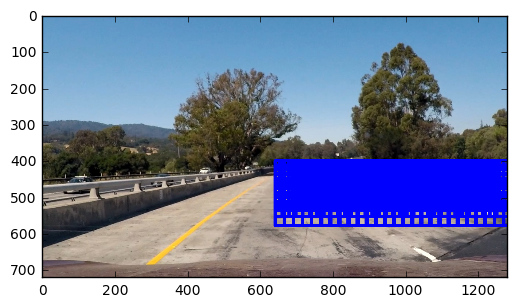

In [17]:
WINDOW_SIZES = [(64, 64), (96, 96), (128, 128)]
WINDOW_Y_START_STOP = [(400, 500), (400, 500), (400, 500)]
WINDOW_OVERLAP = (0.8, 0.8)

# img is of RGB type
def slide_window(img):
    window_list = []
    
    for (xy_window, y_start_stop) in zip(WINDOW_SIZES, WINDOW_Y_START_STOP):
        x_start = int(img.shape[1]/2)
        x_stop = img.shape[1]
        y_start = y_start_stop[0]
        y_stop = y_start_stop[1]
    
        # Compute ROI.
        xspan = x_stop - x_start
        yspan = y_stop - y_start
        
        # Compute the step between successive windows.
        nx_pix_per_step = np.int(xy_window[0] * (1. - WINDOW_OVERLAP[0]))
        ny_pix_per_step = np.int(xy_window[1] * (1. - WINDOW_OVERLAP[1]))
        # Compute the number of windows to generate at this size.
        nx_windows = int(xspan/nx_pix_per_step) - 1
        ny_windows = int(yspan/ny_pix_per_step) - 1
        # Loop through the x and y positions to find the window coordinates.
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                startx = xs*nx_pix_per_step + x_start
                endx = startx + xy_window[0]
                starty = ys*nx_pix_per_step + y_start
                endy = starty + xy_window[1]
                window_list.append(((startx, starty), (endx, endy)))
                
    # Return the list of windows.
    return window_list

img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
windows = slide_window(img)
img = draw_boxes(img, windows)
plt.imshow(img)

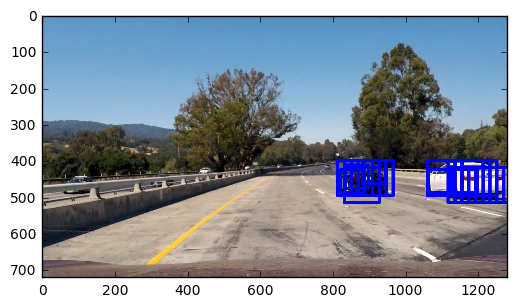

In [18]:
threshold = 0.8

def search_windows(img, windows, clf, scaler):
    # Create a list to hold the positive detections.
    on_windows = []
    
    # Iterate over all the windows in the list.
    for window in windows:
        # Extract the window image from the original image.
        window_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # Convert to the expected BGR in feature extractor.
        window_img = cv2.cvtColor(window_img, cv2.COLOR_RGB2BGR)
        # Extract features for the resized window image
        features = derive_features(window_img)
        # Normalize the extracted features.
        features = scaler.transform(np.array(features).reshape(1, -1))
        # Save the window if prediction is positive.
        if clf.decision_function(features) > threshold:
            on_windows.append(window)
    
    # Return the windows with positive detections.
    return on_windows

img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
windows = slide_window(img)
windows = search_windows(img, windows, classifier, X_scaler)
img = draw_boxes(img, windows)
plt.imshow(img)

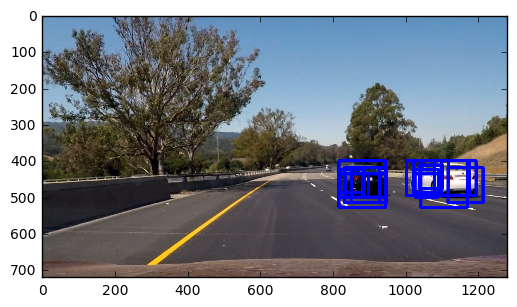

In [19]:
for filename in os.listdir('test_images'):
    img = cv2.imread('test_images/' + filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    windows = slide_window(img)
    windows = search_windows(img, windows, classifier, X_scaler)
    img = draw_boxes(img, windows)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite( filename, img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

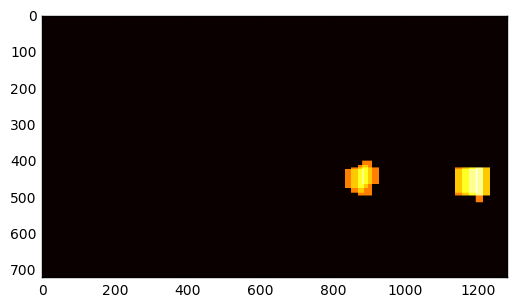

In [20]:
HEATMAP_THRESHOLD = 4

def add_heat(heatmap, bboxes):
    # Iterate through each bbox.
    for bbox in bboxes:
        # Add +1 for all pixels inside each bbox.
        heatmap[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] += 1
    # Return updated heatmap.
    return heatmap
    
def apply_threshold(heatmap):
    # Zero out pixels below the threshold.
    heatmap[heatmap <= HEATMAP_THRESHOLD] = 0
    # Return thresholded map.
    return heatmap

img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
windows = slide_window(img)
windows = search_windows(img, windows, classifier, X_scaler)
heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap, windows)
heatmap = apply_threshold(heatmap)
plt.imshow(heatmap, cmap='hot')

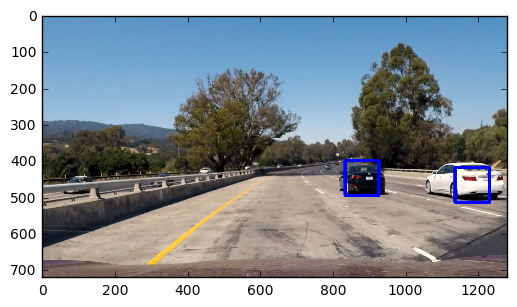

In [21]:
def draw_labeled_bboxes(img, heatmap):
    # Generate the labels from the heat map.
    labels = label(heatmap)
    # Keep a list of bboxes for detected vehicles.
    bboxes = []
    # Iterate through all detected vehicles.
    for vehicle in range(1, labels[1]+1):
        # Find pixels with each vehicle label value.
        nonzero = (labels[0] == vehicle).nonzero()
        # Identify x and y values of those pixels.
        nonzerox = np.array(nonzero[0])
        nonzeroy = np.array(nonzero[1])
        # Define a bounding box based on the min/max x and y.
        bbox = ((np.min(nonzeroy), np.min(nonzerox)), (np.max(nonzeroy), np.max(nonzerox)))
        bboxes.append(bbox)
    # Draw the bounding boxes for the detected vehicles.
    img = draw_boxes(img, bboxes)
    # Return the annotated image.
    return img

img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
windows = slide_window(img)
windows = search_windows(img, windows, classifier, X_scaler)
heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap, windows)
heatmap = apply_threshold(heatmap)
img = draw_labeled_bboxes(img, heatmap)
plt.imshow(img)

In [22]:
for filename in os.listdir('test_images'):
    img = cv2.imread('test_images/' + filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    windows = slide_window(img)
    windows = search_windows(img, windows, classifier, X_scaler)
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, windows)
    heatmap = apply_threshold(heatmap)
    img = draw_labeled_bboxes(img, heatmap)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite('output '+filename, img)

In [23]:
frame_count = 5

class VehicleDetector:
    def __init__(self):
        self.bboxes = []
    
    def add_bboxes(self, bboxes):
        self.bboxes.append(bboxes)
        self.bboxes = self.bboxes[-frame_count:]
    
    def heatmap(self):
        heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
        for bboxes in self.bboxes:
            add_heat(heatmap, bboxes)
        heatmap = apply_threshold(heatmap)
        return heatmap

In [24]:
def pipeline(img, vehicle_detector=None):
    if vehicle_detector is None:
        vehicle_detector = VehicleDetector()
    
    windows = slide_window(img)
    windows = search_windows(img, windows, classifier, X_scaler)
    vehicle_detector.add_bboxes(windows)
    heatmap = vehicle_detector.heatmap()
    img = draw_labeled_bboxes(img, heatmap)
    return img    

In [26]:
filename='test_video.mp4'
vehicle_detector = VehicleDetector()
clip = VideoFileClip(filename)
output = clip.fl_image(lambda img: pipeline(img, vehicle_detector=vehicle_detector))
output.write_videofile('Output-' + filename, audio=False)

[MoviePy] >>>> Building video Output-test_video.mp4
[MoviePy] Writing video Output-test_video.mp4


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 38/39 [01:00<00:01,  1.62s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Output-test_video.mp4 



In [27]:
filename='project_video.mp4'
vehicle_detector = VehicleDetector()
clip = VideoFileClip(filename)
output = clip.fl_image(lambda img: pipeline(img, vehicle_detector=vehicle_detector))
output.write_videofile('Output-' + filename, audio=False)

[MoviePy] >>>> Building video Output-project_video.mp4
[MoviePy] Writing video Output-project_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [31:20<00:01,  1.47s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Output-project_video.mp4 

